In [1]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


#### Single image auto annotation

In [2]:
import os

HOME = os.getcwd()

DATASET_DIR = os.path.join(HOME, "my_dataset")

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TEST_DIRECTORY = os.path.join(DATASET_DIR, "test")

In [3]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor

detector = AutoModelForObjectDetection.from_pretrained("Yifeng-Liu/rt-detr-finetuned-for-satellite-image-roofs-detection")
detector_processor = AutoImageProcessor.from_pretrained("Yifeng-Liu/rt-detr-finetuned-for-satellite-image-roofs-detection")

In [4]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(
            image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(
            image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(
            images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target, image_id

In [5]:
test_dataset = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=detector_processor,
    train=False)

print("Number of test examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of test examples: 967


Image #162
Found valid Image #162


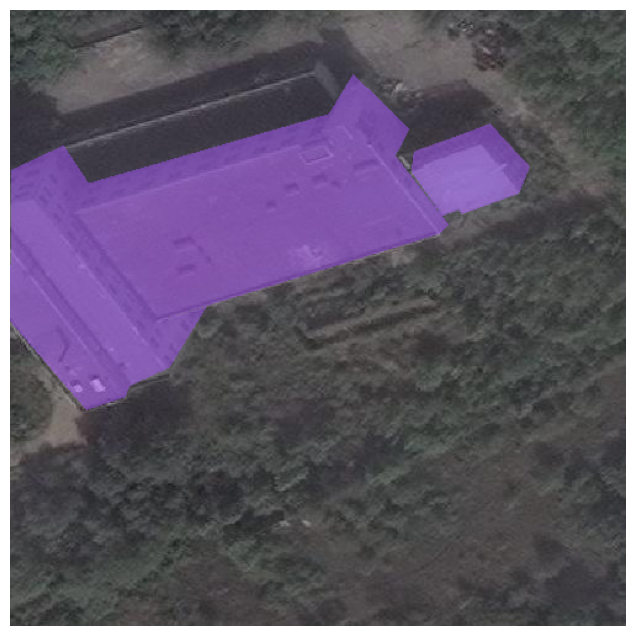

In [6]:
import random
import cv2
import numpy as np
from pycocotools import mask as mask_utils
import supervision as sv

# select random image
image_ids = test_dataset.coco.getImgIds()
image_id = random.choice(image_ids)
# image_id=64
print('Image #{}'.format(image_id))

# load image and annotatons 
image = test_dataset.coco.loadImgs(image_id)[0]
annotations = test_dataset.coco.imgToAnns[image_id]

while not any(ann['bbox'] for ann in annotations):
    # Select another image_id, excluding the current one
    image_ids.remove(image_id)
    image_id = random.choice(image_ids)
    print('Selected new Image #{}'.format(image_id))
    
    # Load the new image and its annotations
    image = test_dataset.coco.loadImgs(image_id)[0]
    annotations = test_dataset.coco.imgToAnns[image_id]

# Now `image_id` has valid annotations with bounding boxes
print(f'Found valid Image #{image_id}')

image_path = os.path.join(test_dataset.root, image['file_name'])
image = cv2.imread(image_path)

def from_coco_annotations(coco_annotation: dict) -> sv.Detections:
        xyxy,masks, class_id = [], [],[]

        for annotation in coco_annotation:
            x_min, y_min, width, height = annotation["bbox"]
            xyxy.append([x_min, y_min, x_min + width, y_min + height])
            class_id.append(annotation["category_id"])
            mask=test_dataset.coco.annToMask(annotation)
            masks.append(mask)
        masks=np.array(masks)
        return sv.Detections(xyxy=np.array(xyxy),mask=masks.astype(bool), class_id=np.array(class_id))
    
detections = from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _,_, class_id, _,_
    in detections
]

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.RichLabelAnnotator(font_size=15)

annotated_frame=image.copy()

# annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
# annotated_frame = label_annotator.annotate(
#     scene=annotated_frame,
#     detections=detections,
#     labels=labels
# )
annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)

%matplotlib inline  
sv.plot_image(annotated_frame, (8, 8))

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIDENCE_TRESHOLD = 0.5

with torch.no_grad():
    detector.to(device)

    # load image and predict
    inputs = detector_processor(images=image, return_tensors='pt').to(device)
    outputs = detector(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = detector_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

In [8]:
det_detections = sv.Detections.from_transformers(
    transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _,
          _, confidence, class_id, _, _ in det_detections]

In [9]:
from supervision.dataset.utils import approximate_mask_with_polygons
from supervision.detection.utils import (
    contains_holes,
    contains_multiple_segments,
)


def filter_small_masks(detections: sv.Detections) -> sv.Detections:
    valid_indices = []
    min_image_area_percentage = 0.002
    max_image_area_percentage = 0.80
    approximation_percentage = 0.75
    for i, mask in enumerate(detections.mask):

        # Check for structural issues in the mask
        if not (contains_holes(mask) or contains_multiple_segments(mask)):
            # Check if the mask can be approximated to a polygon successfully
            if not approximate_mask_with_polygons(mask=mask,
                                                  min_image_area_percentage=min_image_area_percentage,
                                                  max_image_area_percentage=max_image_area_percentage,
                                                  approximation_percentage=approximation_percentage,
                                                  ):
                print(f"Skipping mask {i} due to structural issues")
                continue

        # If all checks pass, add index to valid_indices
        valid_indices.append(i)

    filtered_xyxy = detections.xyxy[valid_indices]
    filtered_mask = detections.mask[valid_indices]
    filtered_confidence = detections.confidence[valid_indices]
    filtered_class_id = detections.class_id[valid_indices]
    filtered_class_name = detections.data['class_name'][valid_indices]

    detections.xyxy = filtered_xyxy
    detections.mask = filtered_mask
    detections.confidence = filtered_confidence
    detections.class_id = filtered_class_id
    detections.data['class_name'] = filtered_class_name
    return detections

In [10]:
from ultralytics.models.fastsam import FastSAMPredictor

overrides = dict(conf=0.25, task="segment", mode="predict", model="FastSAM-x.pt", save=False)
segment_predictor = FastSAMPredictor(overrides=overrides)
everything_results = segment_predictor(image)

if everything_results[0].masks is not None:
    bbox_results = segment_predictor.prompt(everything_results, det_detections.xyxy.tolist())[0]
    seg_detections = sv.Detections.from_ultralytics(bbox_results)
    seg_detections = filter_small_masks(seg_detections)
else:
    print("No segmentation mask generated")
    print(f"Image id:", image_id)


Ultralytics YOLOv8.2.85 🚀 Python-3.12.4 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 Laptop GPU, 16376MiB)
YOLOv8x-seg summary (fused): 295 layers, 72,203,813 parameters, 0 gradients, 345.9 GFLOPs
0: 640x640 3 objects, 19.6ms
Speed: 2.9ms preprocess, 19.6ms inference, 72.0ms postprocess per image at shape (1, 3, 640, 640)
Skipping mask 1 due to structural issues


In [11]:
from shapely.geometry import Polygon, MultiPolygon
from typing import List
import pycocotools.mask as mask_util


def prepare_for_coco_detection(detections):
    coco_results = []
    for original_id, detection in detections.items():
        if len(detection) == 0:
            continue

        boxes = torch.from_numpy(detection.xyxy)
        boxes = torchvision.ops.box_convert(
            boxes, in_fmt="xyxy", out_fmt="xywh").tolist()

        for idx, box in enumerate(boxes):
            score = float(detection.confidence[idx])
            label = int(detection.class_id[idx])

            mask = mask_util.encode(np.asfortranarray(detection.mask[idx].astype(np.uint8)))
            mask["counts"] = mask["counts"].decode("utf-8")
            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": label,
                        "bbox": box,
                        "score": score,
                        "segmentation": mask,
                    }
                ]
            )
    # print(f"detections: {coco_results}")
    return coco_results

In [12]:
from coco_eval import CocoEvaluator

evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["segm"])
predictions = prepare_for_coco_detection({image_id: seg_detections})

evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [13]:
max_length = max(len(name) for name in id2label.values())

# Create a new NumPy array with the appropriate dtype based on the longest string
seg_detections.data['class_name'] = np.array(seg_detections.data['class_name'], dtype=f'<U{max_length}')

for idx, class_name in enumerate(seg_detections.data['class_name']):
    if class_name == 'object':
        seg_detections.data['class_name'][idx] = id2label[seg_detections.class_id[idx]]

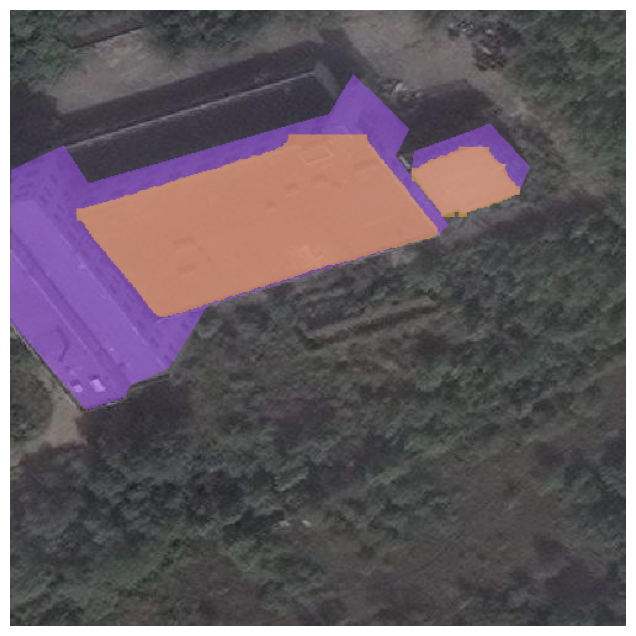

In [14]:
seg_detections.class_id = seg_detections.class_id+4
finial_frame = annotated_frame.copy()
finial_frame = mask_annotator.annotate(scene=finial_frame, detections=seg_detections)
sv.plot_image(finial_frame, (8, 8))

#### Whole dataset auto annotation with batch processing

In [15]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = detector_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    image_ids = [item[2] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels,
        'image_ids': image_ids
    }


test_dataloader = DataLoader(
    dataset=test_dataset, collate_fn=collate_fn, batch_size=4)

In [16]:
from tqdm.notebook import tqdm

print("Running evaluation...")

set_evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["segm"])

detector_failed_list = []
segmentor_failed_list = []

id2label = {0: 'building'}
all_image_ids = []

all_results = []
for idx, batch in enumerate(tqdm(test_dataloader)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    image_ids = batch["image_ids"]

    with torch.no_grad():
        outputs = detector(
            pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)

    detector_results = detector_processor.post_process_object_detection(
        outputs,
        target_sizes=orig_target_sizes)

    detector_detections = []
    detector_to_remove = []

    for idx, detector_result in enumerate(detector_results):
        if detector_result['boxes'].numel() == 0:
            # The tensor is empty
            detector_to_remove.append(idx)
        else:
            detector_detections.append(sv.Detections.from_transformers(transformers_results=detector_result))

    if detector_to_remove is not None:
        # Remove items from detector_results and image_ids by reversing the indices to avoid index shifting
        for idx in sorted(detector_to_remove, reverse=True):
            detector_failed_list.append(image_ids[idx])
            del image_ids[idx]

    images = [test_dataset.coco.loadImgs(image_id)[0] for image_id in image_ids]

    images_raw = [cv2.imread(os.path.join(TEST_DIRECTORY, image['file_name'])) for image in images]

    boxes = [detections.xyxy.tolist() for detections in detector_detections]

    results = []

    to_remove_seg = []

    for idx, (image_id, image, box) in enumerate(zip(image_ids, images_raw, boxes)):
        try:
            with torch.no_grad():
                # segmentation_result = segment_model(image, bboxes=box)[0]
                everything_results = segment_predictor(image)

                if everything_results[0].masks is not None:
                    bbox_results = segment_predictor.prompt(everything_results, box)[0]
                    seg_detections = sv.Detections.from_ultralytics(bbox_results)
                    seg_detections = filter_small_masks(seg_detections)
                    seg_detections.data['class_name'] = np.array(seg_detections.data['class_name'], dtype=f'<U{max_length}')
                    for idx, class_name in enumerate(seg_detections.data['class_name']):
                        if class_name == 'object':
                            seg_detections.data['class_name'][idx] = id2label[seg_detections.class_id[idx]]
                    results.append(seg_detections)
                else:
                    to_remove_seg.append(idx)
        except Exception as e:
            print(f"An error occurred: {e}")
            print(f"box: {box}")
            print(f"image id: {image_id}")
        # result = sv.Detections.from_ultralytics(segmentation_result)
        # results.append(result)

    if to_remove_seg is not None:
        for idx in sorted(to_remove_seg, reverse=True):
            segmentor_failed_list.append(image_ids[idx])
            del image_ids[idx]

    if len(results) != len(image_ids):
        print(f"Length of results ({len(results)}) does not match the length of image_ids ({len(image_ids)})")
        continue

    all_image_ids.extend(image_ids)
    all_results.extend(results)

    predictions = {image_id: output for image_id, output in zip(image_ids, results)}
    predictions = prepare_for_coco_detection(predictions)
    try:
        set_evaluator.update(predictions)
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Predictions: {predictions}")


set_evaluator.synchronize_between_processes()
set_evaluator.accumulate()
set_evaluator.summarize()
print(f"Detetor failed image ids:", detector_failed_list)
print(f"Segmentor failed image ids:", segmentor_failed_list)

Running evaluation...


  0%|          | 0/242 [00:00<?, ?it/s]


0: 640x640 29 objects, 19.0ms
Speed: 1.1ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 objects, 41.6ms
Speed: 0.7ms preprocess, 41.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 25 objects, 19.6ms
Speed: 1.1ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Skipping mask 8 due to structural issues

0: 640x640 3 objects, 19.3ms
Speed: 1.2ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Skipping mask 0 due to structural issues

0: 640x640 15 objects, 17.1ms
Speed: 1.1ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 86 objects, 17.3ms
Speed: 1.1ms preprocess, 17.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 objects, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 28 objects, 1

117,147,183,223,224,241,318,459,472,532,574,575,600,660

#### Saving result in COCO format.

In [17]:
ANNOTATIONS_FILE = './result/_annotations.coco.json'
IMAGE_DIRECTORY = './result/'

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [18]:
from PIL import Image, JpegImagePlugin
from typing import List, Tuple, Dict, Any
from pathlib import Path
import os


def get_dict(
    images: List[Any],
    image_directory: str,
    detections: List[Any]
) -> Tuple[List[str], Dict[str, Any]]:

    detections_dict = {}
    image_paths = []

    # for idx, image in enumerate(images):

    #     file_name = image['file_name']
    #     image_path = os.path.join(image_directory, file_name)
    #     # file_path = os.path.join(save_dir, file_name)

    #     # shutil.copy2(image_path, file_path)
    #     # Append the file path to the list
    #     image_paths.append(image_path)

    #     # Store the detection data
    #     detections_dict[image_path] = detections[idx]
    for image, detection in zip(images, detections):

        file_name = image['file_name']
        image_path = os.path.join(image_directory, file_name)
        # file_path = os.path.join(save_dir, file_name)

        # shutil.copy2(image_path, file_path)
        # Append the file path to the list
        image_paths.append(image_path)

        # Store the detection data
        detections_dict[image_path] = detection

    return image_paths, detections_dict

In [19]:
all_images = test_dataset.coco.loadImgs(all_image_ids)
image_paths, detections_dict = get_dict(
    all_images, TEST_DIRECTORY, all_results)

class_names = ["building"]
sv.DetectionDataset(
    classes=class_names,
    images=image_paths,
    annotations=detections_dict
).as_coco(
    images_directory_path=IMAGE_DIRECTORY,
    annotations_path=ANNOTATIONS_FILE,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

In [20]:
import shutil
from typing import Optional


def compress_folder_to_zip(folder_path: str) -> Optional[str]:
    """
    Compresses the given folder into a zip file at the same level as the folder.

    Parameters:
    folder_path (str): The absolute or relative path to the folder to be compressed.

    Returns:
    Optional[str]: The path to the created zip file, or None if the folder does not exist.
    """
    # Ensure the folder exists
    if not os.path.isdir(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return None

    # Get the absolute path of the folder to avoid any relative path issues
    abs_folder_path = os.path.abspath(folder_path)

    # Extract the folder's parent directory and its name
    folder_dir = os.path.dirname(abs_folder_path)
    folder_name = os.path.basename(abs_folder_path)

    # Define the zip file path (same directory, same name as folder, with .zip extension)
    zip_file_path = os.path.join(folder_dir, f"{folder_name}.zip")

    # Use shutil.make_archive to create the zip file
    shutil.make_archive(base_name=os.path.join(folder_dir, folder_name),
                        format='zip',
                        root_dir=folder_dir,
                        base_dir=folder_name)

    # Return the path to the created zip file
    return zip_file_path

In [21]:
zip_file = compress_folder_to_zip(IMAGE_DIRECTORY)